In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ODE/CO2 gas raw data.csv')
df.head()

,NO,DATE,TEMP,HUM,PM 1.0,PM 2.5,PM 10,CO2,HCHO,CO,...,VOCs,O3,SO2,H2S,O2,NH3,AB,BattV,Heater,Blackout
0,0,2023-07-20_13:12:18,23.5,72.8,59.1,62.9,64.0,701,0,0,...,8.2,0,0,0,268,0,0,0,0,0
1,1,2023-07-20_13:13:18,23.5,72.4,57.9,60.9,61.1,697,0,0,...,41.3,0,0,0,271,0,0,0,0,0
2,2,2023-07-20_13:14:19,23.4,70.1,54.0,56.7,56.7,686,0,0,...,125.3,0,0,0,279,0,0,0,0,0
3,3,2023-07-20_13:15:19,23.3,70.5,54.4,57.0,57.1,692,0,0,...,254.7,0,0,0,284,0,0,0,0,0
4,4,2023-07-20_13:16:19,23.2,71.1,54.6,57.4,57.6,712,0,0,...,272.3,0,0,0,289,0,0,0,0,0


In [41]:
# prompt: cut the df that DATE is above than '2023-07-20_15:41:48'

df_cut = df[df['DATE'] > '2023-07-20_15:42:48']
#df_cut.head()

df_time_versus_co2 = df_cut[['DATE', 'CO2']]
df_time_versus_co2.head()

,DATE,CO2
71,2023-07-20_15:43:48,2852
72,2023-07-20_15:44:48,2168
73,2023-07-20_15:45:49,1982
74,2023-07-20_15:46:49,1872
75,2023-07-20_15:47:49,1830


In [42]:
# prompt: df_time_versus_co2 DataFrame 사용: make date value as timeline

df_time_versus_co2['DATE'] = pd.to_datetime(df_time_versus_co2['DATE'], format='%Y-%m-%d_%H:%M:%S')
df_time_versus_co2['DATE']

<ipython-input-42-bc04ccca9d6d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_versus_co2['DATE'] = pd.to_datetime(df_time_versus_co2['DATE'], format='%Y-%m-%d_%H:%M:%S')


71    2023-07-20 15:43:48
72    2023-07-20 15:44:48
73    2023-07-20 15:45:49
74    2023-07-20 15:46:49
75    2023-07-20 15:47:49
              ...        
406   2023-07-20 21:19:57
407   2023-07-20 21:20:57
408   2023-07-20 21:21:57
409   2023-07-20 21:22:57
410   2023-07-20 21:23:57
Name: DATE, Length: 340, dtype: datetime64[ns]

In [43]:
# prompt: convert df_time_versus_co2['DATE'] value as 0, 1, 2, ...

df_time_versus_co2['DATE'] = (df_time_versus_co2['DATE'] - df_time_versus_co2['DATE'].iloc[0]).dt.seconds // 60
df_time_versus_co2.head()


<ipython-input-43-d53b61558bcc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_versus_co2['DATE'] = (df_time_versus_co2['DATE'] - df_time_versus_co2['DATE'].iloc[0]).dt.seconds // 60


,DATE,CO2
71,0,2852
72,1,2168
73,2,1982
74,3,1872
75,4,1830


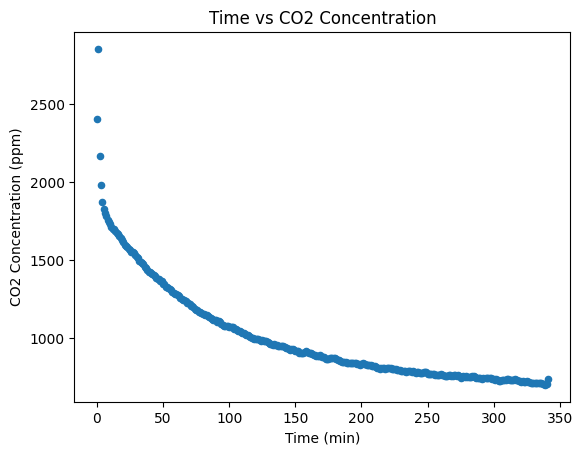

In [28]:
# prompt:

# Create a line plot with date on the x-axis and CO2 concentration on the y-axis
df_time_versus_co2.plot(x='DATE', y='CO2', kind='scatter')
import matplotlib.pyplot as plt
# Set the title of the plot
plt.title('Time vs CO2 Concentration')

# Set the x-axis label
plt.xlabel('Time (min)')

# Set the y-axis label
plt.ylabel('CO2 Concentration (ppm)')

# Show the plot
plt.show()


In [85]:
import numpy as np
from scipy.optimize import curve_fit

# Extracting the relevant data
x_data = df_time_versus_co2['DATE'].values
y_data = df_time_versus_co2['CO2'].values

# Define the function
def piecewise_func_back(x, a, b, c, d, e, f, xr):
    return np.where(x <= xr,
                    a*np.exp(-b*x)+c,
                    d*np.exp(-e*(x-xr))+f)

# Initialize best fit parameters and the corresponding error
best_params = None
lowest_error = float('inf')

# Iterate over a range of possible xr values
for xr in np.linspace(1, 2, 100):  # Fine-grained search within the interval
    try:
        # Fit the model to the data
        params, _ = curve_fit(lambda x, a, b, c, d, e, f: piecewise_func_back(x, a, b, c, d, e, f, xr), x_data, y_data, p0=[1, 1, 0, 1, 1, 0])

        # Calculate the sum of squared errors
        fitted_values = piecewise_func_back(x_data, params[0], params[1], params[2], params[3], params[4], params[5], xr)
        error = np.sum((y_data - fitted_values) ** 2)

        # Update best parameters if this fit is better
        if error < lowest_error:
            best_params = (params[0], params[1], params[2], params[3], params[4], params[5], xr)
            lowest_error = error
    except RuntimeError:
        # In case the fitting fails for a specific set of parameters
        continue

# Best parameters and the corresponding error
print(best_params, lowest_error)
# Unpack the updated best parameters
a_best, b_best, c_best, d_best, e_best, f_best, xr_best = best_params

# Generate fitted values with updated parameters
fitted_y = piecewise_func_back(x_data, a_best, b_best, c_best, d_best, e_best, f_best, xr_best)


<ipython-input-85-0ec415e2d377>:11: RuntimeWarning: overflow encountered in exp
  a*np.exp(-b*x)+c,
<ipython-input-85-0ec415e2d377>:12: RuntimeWarning: overflow encountered in exp
  d*np.exp(-e*(x-xr))+f)
<ipython-input-85-0ec415e2d377>:12: RuntimeWarning: overflow encountered in multiply
  d*np.exp(-e*(x-xr))+f)
<ipython-input-85-0ec415e2d377>:11: RuntimeWarning: overflow encountered in multiply
  a*np.exp(-b*x)+c,
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(939.4698795180726, 1.3022112439093476, 1912.5301204819273, 1106.496275130064, 0.011287442091666277, 705.3560403767948, 2.0) 30459.12617368626


In [86]:
fitted_equation_lines = [
        f"Fitted Equation:",
        f"y = a*e^(-b*x)+c for x <= tr",
        f"y = d*e^(-e*(x-tr))+f for x > tr",
        f"where a = {a_best:.2f}, b = {b_best:.2f},",
        f"c = {c_best:.2f}, d = {d_best:.2f},",
        f"e = {e_best:.2f}, f = {f_best:.2f}, tr = {xr_best:.2f}"
    ]
fitted_equation_lines

['Fitted Equation:',
 'y = a*e^(-b*x)+c for x <= tr',
 'y = d*e^(-e*(x-tr))+f for x > tr',
 'where a = 939.47, b = 1.30,',
 'c = 1912.53, d = 1106.50,',
 'e = 0.01, f = 705.36, tr = 2.00']

In [91]:
def conc_fit(x, a, b, c, d, e):
    return a * np.exp(-b*x) + c * np.exp(-d*x) + e

params, _ = curve_fit(lambda x, a, b, c, d, e: conc_fit(x, a, b, c, d, e), x_data, y_data, p0=[1, 1, 1, 1, 0])

# Initialize best fit parameters and the corresponding error
best_params = None
lowest_error = float('inf')

# Calculate the sum of squared errors
fitted_values = conc_fit(x_data, params[0], params[1], params[2], params[3], params[4])
error = np.sum((y_data - fitted_values) ** 2)

# Update best parameters if this fit is better
if error < lowest_error:
    best_params = (params[0], params[1], params[2], params[3], params[4])
    lowest_error = error

# Unpack the updated best parameters
a_best, b_best, c_best, d_best, e_best = best_params

# Generate fitted values with updated parameters
fitted_y = conc_fit(x_data, a_best, b_best, c_best, d_best, e_best)

<ipython-input-91-5e2b3f12136a>:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b*x) + c * np.exp(-d*x) + e
<ipython-input-91-5e2b3f12136a>:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b*x) + c * np.exp(-d*x) + e


In [97]:
fitted_equation_lines = [
        f"Fitted Equation:",
        f"y = a*e^(-b*x) + c*e^(-d*x) + e",
        f"where a = {a_best:.3f}, b = {b_best:.3f},",
        f"c = {c_best:.3f}, d = {d_best:.3f}, e = {e_best:.3f}"
    ]
fitted_equation_lines

['Fitted Equation:',
 'y = a*e^(-b*x) + c*e^(-d*x) + e',
 'where a = 1127.452, b = 0.011,',
 'c = 1011.547, d = 0.957, e = 703.879']

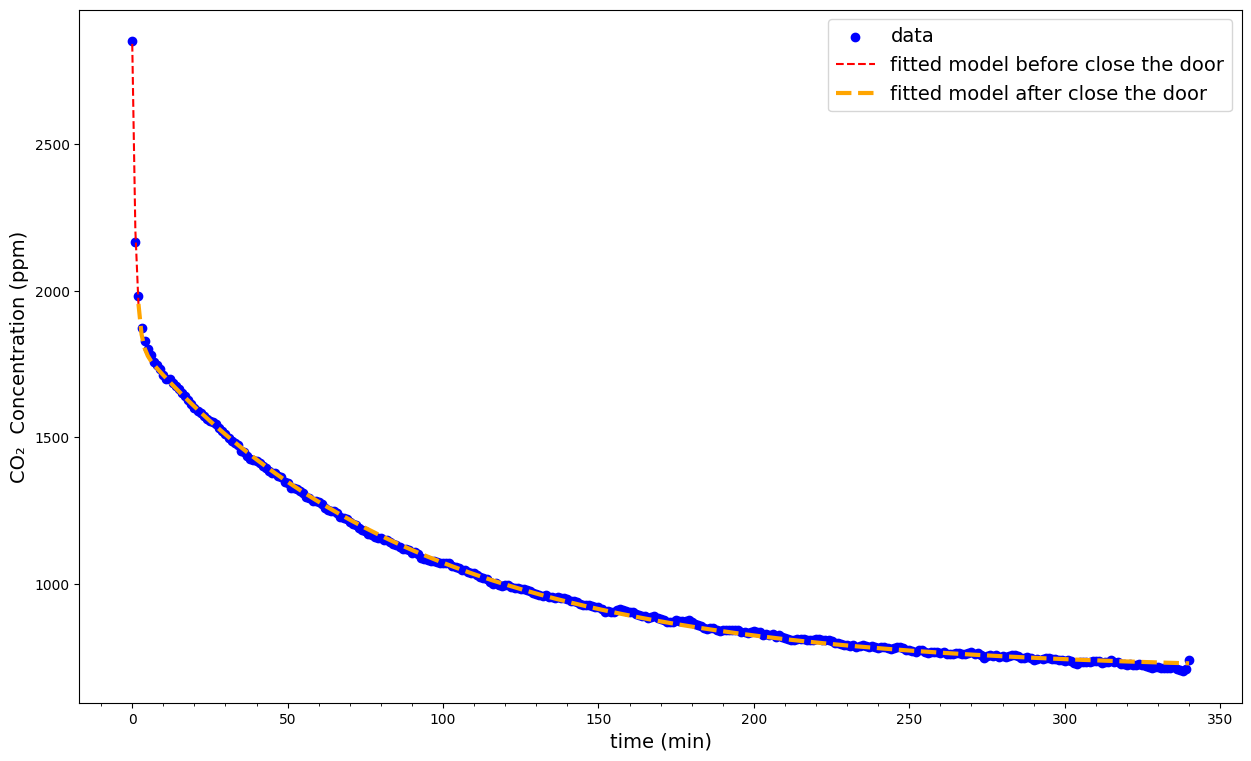

In [106]:
# Plotting with updated fit
plt.figure(figsize=(15, 9))
plt.scatter(x_data, y_data, label = 'data', color='blue')
plt.plot(x_data[0:3], fitted_y[0:3], color='red', label = 'fitted model before close the door', linestyle='--')
plt.plot(x_data[2:], fitted_y[2:], color='orange', label = 'fitted model after close the door', linestyle='--', linewidth=3)
#xticks_labels = [f'{hour} (min)' for hour in x_data]
#plt.xticks(x_data, xticks_labels, rotation=45)
#plt.axvline(x=xr_best, color='black', linestyle=':', label=f'$t_r = {int(xr_best)}$ ')
ax = plt.gca()
ax.xaxis.set_minor_locator(plt.MultipleLocator(10))
#plt.title('Time vs CO2 Concentration') # 샘플 이름으로 변경
plt.xlabel('time (min)', size=14)
plt.ylabel('CO₂  Concentration (ppm)', size=14)
plt.legend(fontsize=14)
#plt.text(0.7, 0.6, '\n'.join(fitted_equation_lines), fontsize=12, \
#         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plt.savefig('/content/drive/MyDrive/ODE/240511_CO2_plot_without_tr.png', dpi=300)